In [37]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
from scipy.optimize import curve_fit

import cmath

from runge_kutta import RungeKuttaLoose
from plotting import *
from eigenvalues import *
from helper_functions import read_simulation, read_all_simulations

In [5]:
vi = 0.01
Vol = vi*10**(-14); NA = 6.02*10**(23); Cal = NA*Vol*10**(-6)
TC = 0.158
kc1 = 0.15*Cal*TC
# production of p53 [molecules/min]
kc2 = 0.1*TC
# degradation of p53 by mdm2 [1/min]
kc3 = 0.1*Cal
# degradation of p53 by mdm2 [molecules]
kc4 = 0.1/Cal*TC
# production of mdm2 - mRNA [1/(molecules*min)]
kc5 = 0.1*TC 
# degradation of mdm2 - mRNA [1/min]
kc6 = 0.2*TC 
# production of mdm2 [1/min]
kc7 = 0.1*TC 
# degradation of mdm2 [1/min]
kc8 = 0.0036 
# binding of mdm2 and nutlin [1/(molecules*min)]

### Load simulationer

In [6]:
all_simulations = read_all_simulations("simulations.h5")

In [7]:
specific_simulation = read_simulation("simulations.h5", 0.00558)

### Plotting

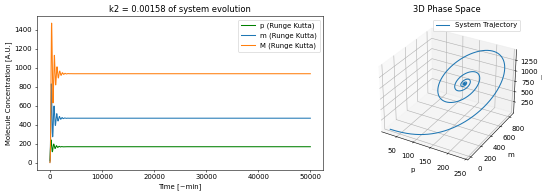

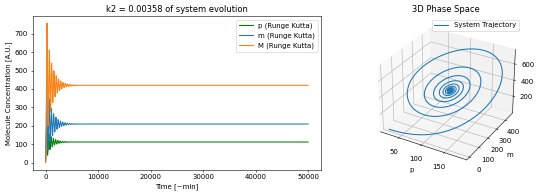

KeyboardInterrupt: 

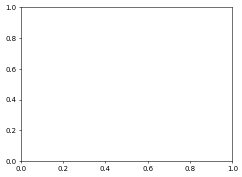

In [8]:
plot_systems_evolution_2d_3d(simulations = all_simulations, single_fig = False, dpi = 50, filename = "testing", save_fig=False)

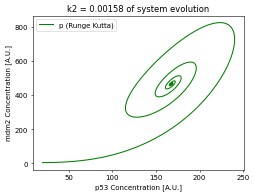

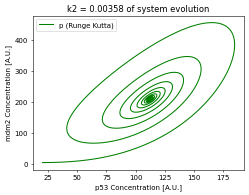

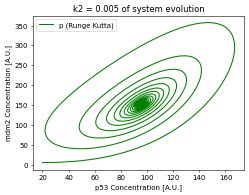

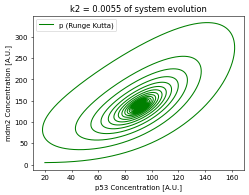

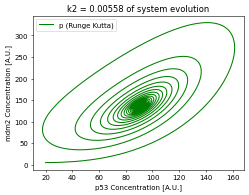

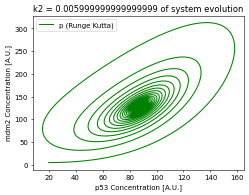

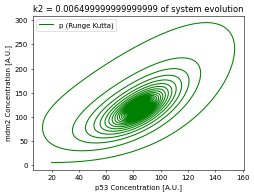

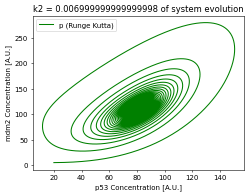

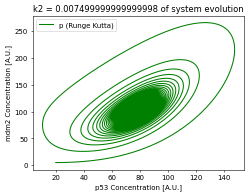

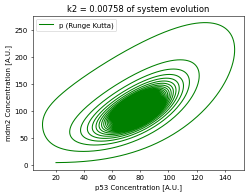

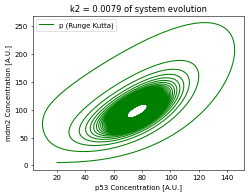

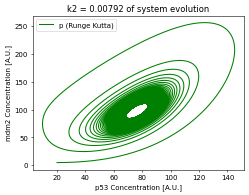

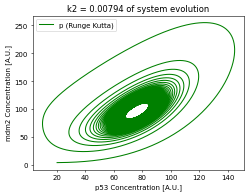

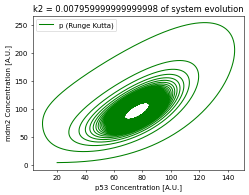

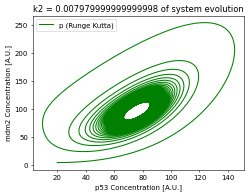

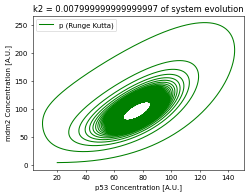

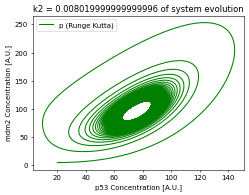

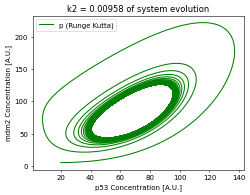

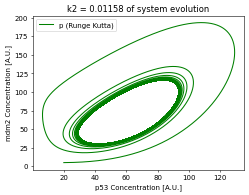

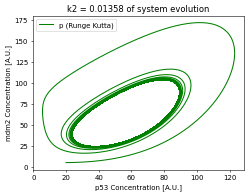

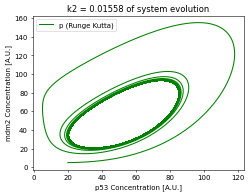

In [47]:
plot_systems_evolution_p53vsmdm2(simulations = all_simulations, single_fig = False, dpi = 50, filename = "testing", save_fig=False)

### Slice and Plot

In [9]:
def slice_trajectory(simulation_dict, time_start, time_end):
    """
    Slices the trajectory of a simulation to keep only the data within the specified time range.

    Parameters:
    - simulation_dict: dict, containing simulation data with keys "k2_val", "trajectory", and "time".
    - time_start: float, the start of the time range.
    - time_end: float, the end of the time range.

    Returns:
    - A dictionary with the same structure as simulation_dict but with the trajectory data sliced to the specified time range.
    """
    # Extract the trajectory and time arrays
    p_values = simulation_dict["trajectory"]["p"]
    m_values = simulation_dict["trajectory"]["m"]
    M_values = simulation_dict["trajectory"]["M"]
    time_arr = simulation_dict["time"]

    # Find indices where time is within the specified range
    indices = [i for i, t in enumerate(time_arr) if time_start <= t <= time_end]
    
    # Slice arrays based on the found indices
    sliced_trajectory = {
        "k2_val": simulation_dict["k2_val"],
        "trajectory": {
            "p": [p_values[i] for i in indices],
            "m": [m_values[i] for i in indices],
            "M": [M_values[i] for i in indices],
        },
        "time": [time_arr[i] for i in indices]
    }

    return sliced_trajectory

def sliced_simulations(simulations_dictionary, t_start, t_end):
    sliced = []
    for simulation in simulations_dictionary:
        sliced.append(slice_trajectory(simulation, t_start, t_end))
    
    return sliced

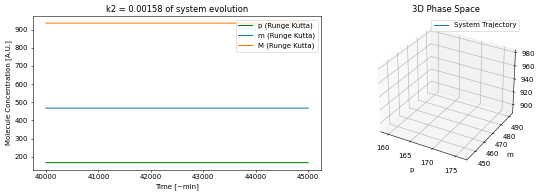

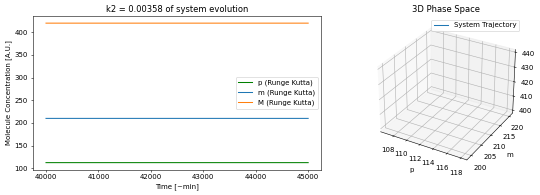

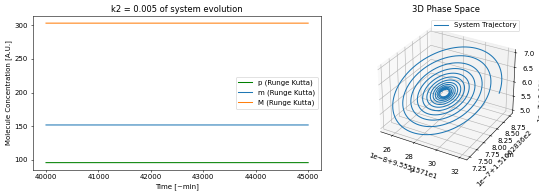

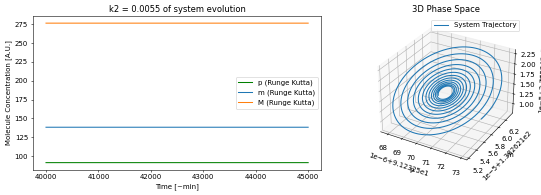

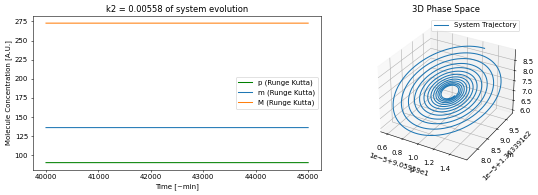

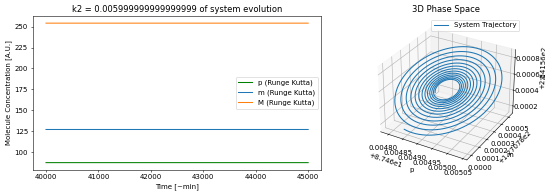

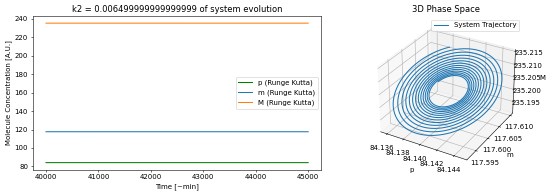

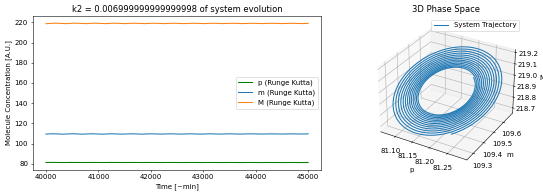

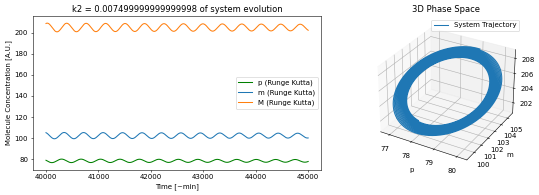

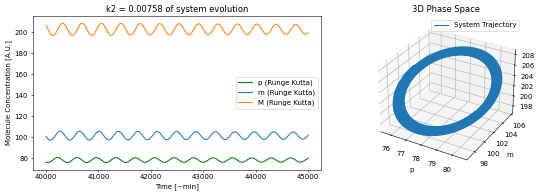

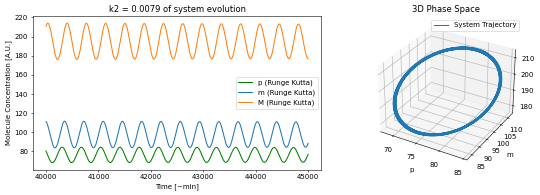

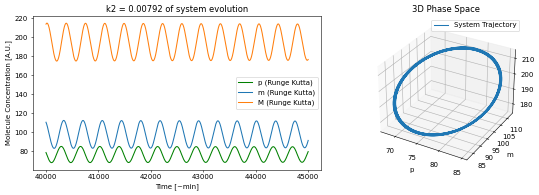

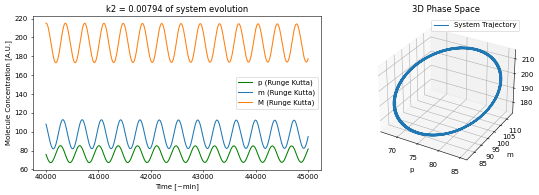

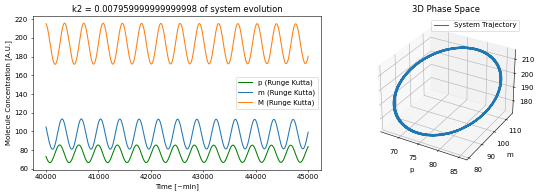

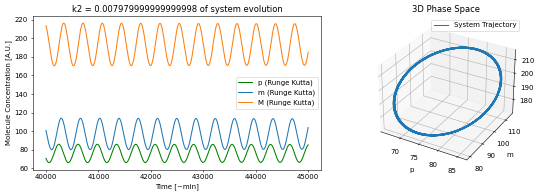

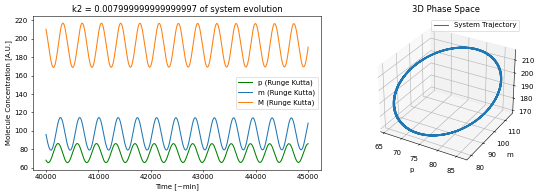

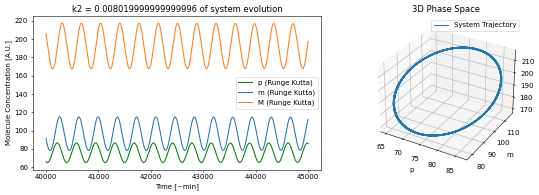

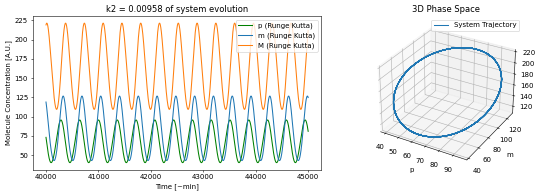

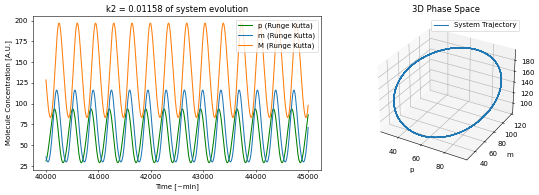

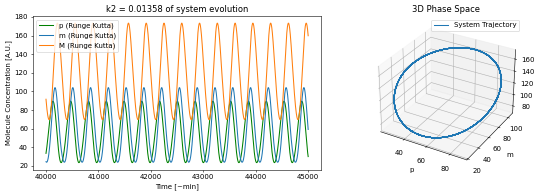

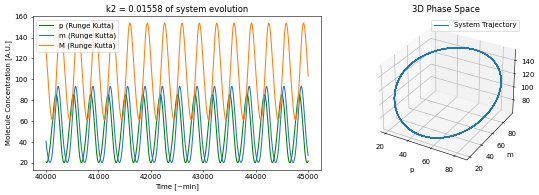

In [45]:
# sliced = sliced_simulations(simulations_dict, 60000, 70000)
sliced = sliced_simulations(all_simulations, 40000, 45000)
plot_systems_evolution_2d_3d(simulations = sliced, single_fig = False, dpi = 50, filename = "testing", save_fig=False)
# plot_systems_evolution_p53vsmdm2(sliced2, save_fig=False, filename="p53vsmdm2", single_fig=False)

### Find fikspunkter

In [10]:
# Function for choosing simulations ending in fixed point.
def find_fixed_points_simulations(simulations):
    fixed_points = []
    for simulation in simulations:
        # Access the specific structure as described
        last_five_values = np.round(simulation["trajectory"]["p"][-5:], 4)
        
        # Check if the last five values are the same
        if np.all(last_five_values == last_five_values[0]):    
            fixed_points.append({"k2_val": simulation["k2_val"], "p": simulation["trajectory"]["p"][-1], "m": simulation["trajectory"]["m"][-1], "M": simulation["trajectory"]["M"][-1], "time_final": simulation["time"][-1]})
    
    print(f"No. of simulations settling to fixed points: {len(fixed_points)}")
    return fixed_points

In [11]:
fixed_points_test = find_fixed_points_simulations(all_simulations)

No. of simulations settling to fixed points: 8


### Eigenvalues

In [12]:
import sympy as sp
from sympy.abc import p, m, M
from sympy import Matrix
import numpy as np
import matplotlib.pyplot as plt

sp.init_printing()

#definerer symbolerne for parameterne
k1 = sp.Symbol('k1')
k2 = sp.Symbol('k2')
k3 = sp.Symbol('k3')
k4 = sp.Symbol('k4')
k5 = sp.Symbol('k5')
k6 = sp.Symbol('k6')
k7 = sp.Symbol('k7')

#definerer funktioner
dp = k1 - k2 * (M * p) / (k3 + p)
dm = k4 * p**2 - k5 * m
dM = k6 * m - k7 * M

#udregner indgange jacobiantmatricen
ddpdp = sp.diff(dp, p)
ddpdm = sp.diff(dp, m)
ddpdM = sp.diff(dp, M)
ddmdp = sp.diff(dm, p)
ddmdm = sp.diff(dm, m)
ddmdM = sp.diff(dm, M)
ddMdp = sp.diff(dM, p)
ddMdm = sp.diff(dM, m)
ddMdM = sp.diff(dM, M)

#defienrer jacobiantmatricen
jacobian = Matrix([[ddpdp, ddpdm, ddpdM], [ddmdp, ddmdm, ddmdM], [ddMdp, ddMdm, ddMdM]])

In [13]:

#laver funktion som udregner egenværdier med fikspunkt og k2 som input
def eigenvals(fp):
    #indsætter paramtere og fikspunkt i jacobianten
    ev_jac = jacobian.subs({p: fp["p"], m: fp["m"], M: fp["M"], k1: kc1, k2: fp["k2_val"], k3: kc3, k4: kc4, k5: kc5, k6: kc6, k7: kc7})
    #defienerer liste med nuller
    # eigenvalues = []
    #fylder listen ud med egenværdier
    # for i in range (len(jacobian[0,:])):
    #     print(list(ev_jac.eigenvals().keys()))
        # eigenvalues[i] = sp.re(list(ev_jac.eigenvals().keys()))
    eigenvalues = {"k2_val": fp["k2_val"], "eigenvalues": [complex(real_part, imag_part) for real_part, imag_part in [(expr.as_real_imag()) for expr in list(ev_jac.eigenvals().keys())]]}
    # for expr in list(ev_jac.eigenvals().keys()):
        # print(expr.as_real_imag())
    return eigenvalues

In [14]:
def find_all_eigenvals(array_of_fp):
    all_eigen = []
    for fp in array_of_fp:
        all_eigen.append(eigenvals(fp))
    return all_eigen

In [15]:
all_eigenvalues = find_all_eigenvals(fixed_points_test)

In [16]:
display(all_eigenvalues)

[{'k2_val': '0.00158',
  'eigenvalues': [(-0.028146075793001265-3.1296361596292583e-34j),
   (-0.001874207173876351-0.012244593973741833j),
   (-0.001874207173876351+0.012244593973741833j)]},
 {'k2_val': '0.00358',
  'eigenvalues': [(-0.030394368103604803+2.7759926776997105e-34j),
   (-0.0009253482314120041-0.014591676442775888j),
   (-0.0009253482314120041+0.014591676442775888j)]},
 {'k2_val': '0.005',
  'eigenvalues': [(-0.03142416551100761+5.842767935642584e-34j),
   (-0.0005304050727020493-0.015620141728439195j),
   (-0.0005304050727020493+0.015620141728439195j)]},
 {'k2_val': '0.0055',
  'eigenvalues': [(-0.03173136141011182+7.169602559220299e-34j),
   (-0.0004183359814425626-0.015921875177167994j),
   (-0.0004183359814425626+0.015921875177167994j)]},
 {'k2_val': '0.00558',
  'eigenvalues': [(-0.0004014048213341068-0.015967925438071646j),
   (-0.0004014048213341068+0.015967925438071646j),
   (-0.031778450324936786+0j)]},
 {'k2_val': '0.005999999999999999',
  'eigenvalues': [(-0.03

In [54]:
def plot_egenvaerdier(matrix_med_egenvaerdier):
    zoom = 0.1  # Smaller values = closer zoom

    # Adjust the figure size dynamically based on the zoom or set it to a fixed size that works well with your zoom level
    plt.figure(figsize=(6, 6))  # You may need to experiment with these dimensions

    for i, row in enumerate(matrix_med_egenvaerdier):
        reel = [z.real for z in row["eigenvalues"]]
        imaginær = [z.imag for z in row["eigenvalues"]]
        plt.scatter(reel, imaginær, label=f'Row {i+1}')

        # for j, z in enumerate(row):
        #     print(z["k2_val"])
            # shift = zoom * 0.05  # Adjusted shift to be proportional to the zoom level
            # plt.text(z["eigenvalues"].real + shift, z["eigenvalues"].imag + shift, f'{i+1}', fontsize=9, ha='center', va='center', color="red")

    # Set plot limits directly based on the zoom level
    plt.xlim(-zoom, zoom)
    plt.ylim(-zoom, zoom)

    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)

    plt.xscale("symlog", linscale=10)
    
    plt.xlabel('Reel')
    plt.ylabel('Imaginær')
    plt.title('Plot of egenværdier for varierende værdier af k2')

    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit the plot

    # Optionally adjust margins further if necessary
    # plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

    plt.show()


In [55]:
def plot_real(matrix_med_eigenvals):
    zoom = 0.1  # Smaller values = closer zoom

    # Adjust the figure size dynamically based on the zoom or set it to a fixed size that works well with your zoom level
    plt.figure(figsize=(6, 6))  # You may need to experiment with these dimensions
    for i, row in enumerate(matrix_med_eigenvals):
        reel = [z.real for z in row["eigenvalues"]]
        nul_array = [0 for r in reel]
        plt.scatter(reel, nul_array, label=f'Row {i+1}')

        # for j, z in enumerate(row):
        #     print(z.keys())
            # shift = zoom * 0.05  # Adjusted shift to be proportional to the zoom level
            # plt.text(z["eigenvalues"].real + shift, z["eigenvalues"].imag + shift, f'{i+1}', fontsize=9, ha='center', va='center', color="red")

    # Set plot limits directly based on the zoom level
    plt.xlim(-0.001, 0.001)
    plt.ylim(-0.1, 0.1)

    plt.axhline(0, color='black', linewidth=1)
    plt.axvline(0, color='black', linewidth=1)

    # plt.xscale("symlog", linscale=10)

    plt.xlabel('Reel')
    plt.ylabel('Imaginær')
    plt.title('Plot of egenværdier for varierende værdier af k2')

    plt.grid(True)
    plt.tight_layout()  # Adjust layout to fit the plot

    # Optionally adjust margins further if necessary
    # plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)

    plt.show()


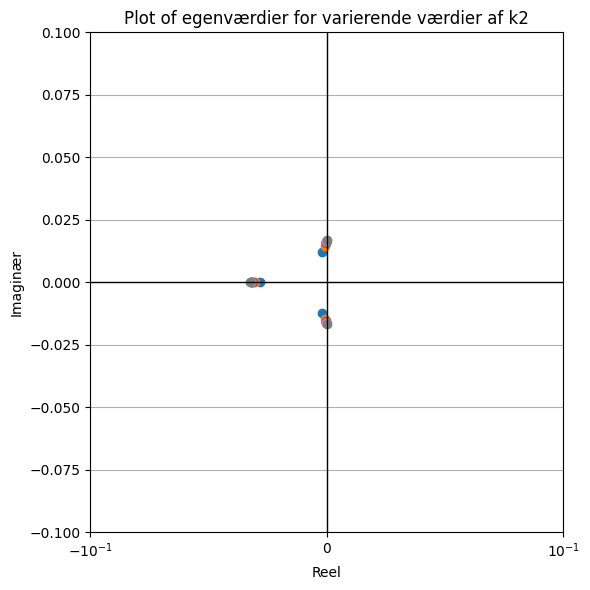

In [56]:
plot_egenvaerdier(all_eigenvalues)

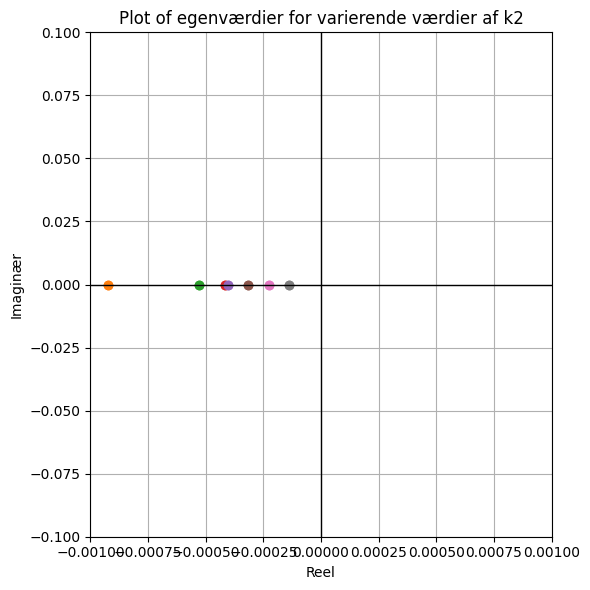

In [44]:
plot_real(all_eigenvalues)

### Reelle del egenværdi 2 og 3 som funktion af k2

In [91]:
k2_values = []
first_eigenvalues = []

for entry in all_eigenvalues:
    # Extract k2 value and append to k2_values list
    k2_values.append(float(entry['k2_val']))

    first_eigenvalues.append(abs(entry['eigenvalues'][1].real))

In [92]:
# Perform polynomial regression
degree = 4  # Choose the degree of the polynomial
coefficients = np.polyfit(k2_values, first_eigenvalues, degree)
a, b, c, d, e = coefficients

In [93]:
yfire = a *  xdummy**4 + b * xdummy**3  + c * xdummy**2  + d * xdummy + e
xdummy = np.linspace(0, 0.010, 100)

In [94]:
import scipy.optimize as sco
def nulløsning(x):
    return a *  x**4 + b * x**3  + c * x**2  + d * x + e

root = sco.fsolve(nulløsning, x0=0)

k2c= [0.00805608]


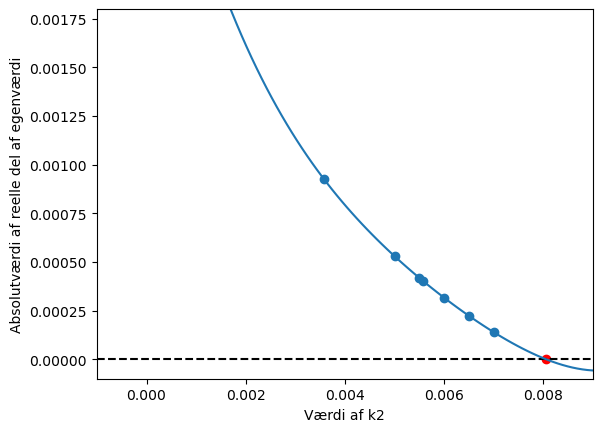

In [99]:
plt.scatter(k2_values, first_eigenvalues)
plt.xlim(-0.001,0.009)
plt.ylim(-0.0001,0.00180)
plt.axhline(y=0, color='black', linestyle='--')
plt.xlabel("Værdi af k2")
plt.ylabel("Absolutværdi af reelle del af egenværdi")
plt.plot(xdummy, yfire)
plt.scatter(root, 0, color="red")
print("k2c=",root)